In [280]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

In [281]:
train_data = torchvision.datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor())

test_data = torchvision.datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform = torchvision.transforms.ToTensor())

In [282]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

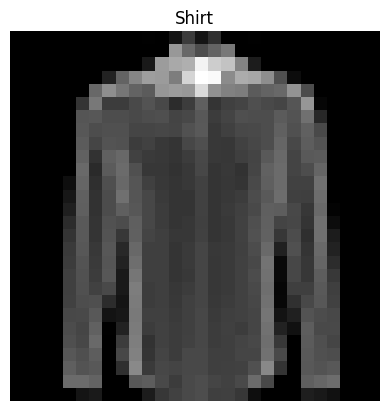

In [283]:
img, label = train_data[22580]
plt.imshow(img.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.axis('off')
plt.show()


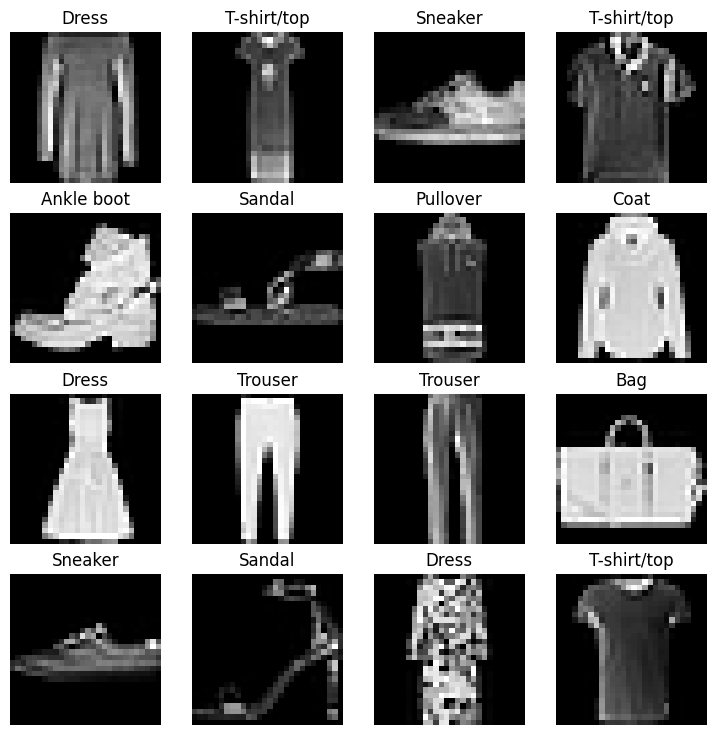

In [284]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4

for i in range(1, (rows*cols)+1):
    rand_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[rand_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(class_names[label])
    plt.axis(False)

In [285]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=32,
                             shuffle=False)

In [286]:
len(train_data), len(train_dataloader)

(60000, 1875)

In [287]:
class FashionMNISTModel(nn.Module):
    def __init__(self, input_shape: int, hidden_untis: int, output_shape: int):
        super().__init__()

        self.conv_layer_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_untis,
                  kernel_size=3,
                  padding=1,
                  stride=1),

        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_untis,
                  out_channels=hidden_untis,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))

        self.conv_layer_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_untis,
                  out_channels=hidden_untis,
                  kernel_size=3,
                  padding=1,
                  stride=1),

        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_untis,
                  out_channels=hidden_untis,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(out_features=output_shape))
        

    def forward(self, x):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.classifier(x)
        return x




In [288]:
torch.manual_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = FashionMNISTModel(input_shape=1,
                          hidden_untis=10,
                          output_shape=len(class_names)).to(device)

In [289]:
import requests
from pathlib import Path

url = 'https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py'

if Path('helper_functions').is_file():
    print('Already exists!')
else:
    print('Downloading..........')
    requests = requests.get(url)
    with open('helper_functions.py', 'wb') as f:
        f.write(requests.content)

Already exists!


In [290]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

In [291]:
def train(model: torch.nn.Module,
          data_loader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          accuracy_fn,
          device: torch.device=device):
    
    train_loss, train_acc = 0, 0

    model.train()
    for batch, (X, y) in enumerate(data_loader):
        X , y = X.to(device), y.to(device)

        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    print(f'Train loss: {train_loss:4f} | Train acc: {train_acc:.2f}%')

In [292]:
def test(model: torch.nn.Module,
         data_loader: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         accuracy_fn,
         device: torch.device=device):
    
    test_loss, test_acc = 0, 0

    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)
            test_loss += loss_fn(y_pred, y).item()
            test_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

        print(f'Test loss: {test_loss:4f} | Test acc: {test_acc:.2f}%\n')

In [293]:
from tqdm.auto import tqdm

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}\n--------------')

    train(model=model,
          data_loader=train_dataloader,
          loss_fn=loss_fn,
          optimizer=optimizer,
          accuracy_fn=accuracy_fn,
          device=device)
    
    test(model=model,
         data_loader=test_dataloader,
         loss_fn=loss_fn,
         accuracy_fn=accuracy_fn,
         device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
--------------
Train loss: 1.407402 | Train acc: 47.89%
Test loss: 0.703249 | Test acc: 73.56%

Epoch: 1
--------------
Train loss: 0.561216 | Train acc: 79.84%
Test loss: 0.503023 | Test acc: 82.32%

Epoch: 2
--------------
Train loss: 0.454308 | Train acc: 83.78%
Test loss: 0.443535 | Test acc: 84.39%



In [300]:
import random
# torch.manual_seed(42)

test_samples = []
test_labels = []

# Randomly sample 9 unique (image, label) pairs from test dataset
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)


In [301]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device=device):
    
    pred_probs = []
    model.to(device)

    with torch.inference_mode():
        for sample in data:
            # Add batch dimension → [C, H, W] → [1, C, H, W]
            sample = torch.unsqueeze(sample, dim=0).to(device)

            pred_logits = model(sample)

            # .squeeze() removes batch dim → [num_classes], then softmax over class dim (dim=0)
            pred_prob = torch.softmax(pred_logits.squeeze(), dim=0)

            pred_probs.append(pred_prob.cpu())
            
    # Stack list of tensors into single tensor
    return torch.stack(pred_probs)

In [302]:
pred_probs = make_predictions(model=model,
                              data=test_samples,
                              device=device)

pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([2, 9, 3, 3, 8, 4, 4, 0, 3])

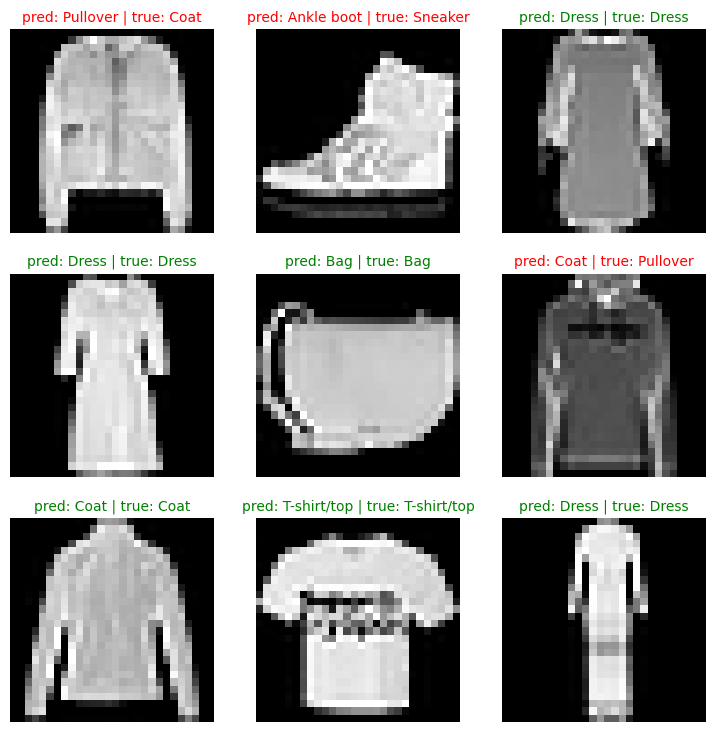

In [303]:
fig = plt.figure(figsize=(9,9))
rows, cols = 3, 3

for i, sample in enumerate(test_samples):
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(sample.squeeze(), cmap='gray')

    pred_label = class_names[pred_classes[i]]
    true_label = class_names[test_labels[i]]

    if pred_label == true_label:
        plt.title(f'pred: {pred_label} | true: {true_label}', fontsize=10, c='g')
    else:
        plt.title(f'pred: {pred_label} | true: {true_label}', fontsize=10, c='r')

    plt.axis(False)

In [298]:
y_preds = []
model.eval()
with torch.inference_mode():
    for X , y in (test_dataloader):
        X, y = X.to(device), y.to(device)

        y_logits = model(X)
        y_pred = y_logits.argmax(dim=1)
        y_preds.append(y_pred)


# Concatenate all batch predictions into single 1D tensor
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor.shape

torch.Size([10000])

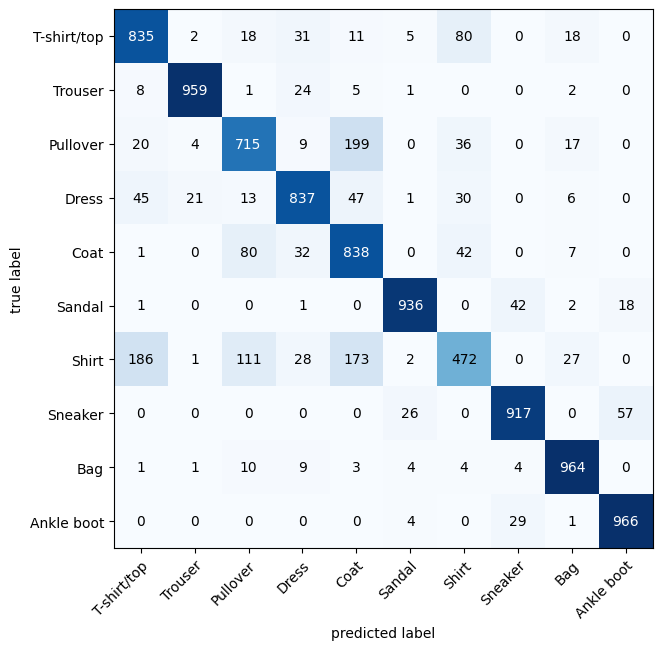

In [299]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Initialize confusion matrix for multi-class classification
confmat = ConfusionMatrix(task='multiclass', num_classes=len(class_names))

# Compute confusion matrix using model predictions and true labels
confmat_tensor = confmat(preds=y_pred_tensor.cpu(), target=test_data.targets)

# Plot confusion matrix with readable class names and custom figure size
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),   # Convert to NumPy array for plotting
    class_names=class_names,           # Display human-readable class labels
    figsize=(10, 7)
    )

In [304]:
confmat_tensor

tensor([[835,   2,  18,  31,  11,   5,  80,   0,  18,   0],
        [  8, 959,   1,  24,   5,   1,   0,   0,   2,   0],
        [ 20,   4, 715,   9, 199,   0,  36,   0,  17,   0],
        [ 45,  21,  13, 837,  47,   1,  30,   0,   6,   0],
        [  1,   0,  80,  32, 838,   0,  42,   0,   7,   0],
        [  1,   0,   0,   1,   0, 936,   0,  42,   2,  18],
        [186,   1, 111,  28, 173,   2, 472,   0,  27,   0],
        [  0,   0,   0,   0,   0,  26,   0, 917,   0,  57],
        [  1,   1,  10,   9,   3,   4,   4,   4, 964,   0],
        [  0,   0,   0,   0,   0,   4,   0,  29,   1, 966]])